In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 用户设定

data = pd.read_csv('processed_data_modified.csv')
print("Number of rows:", data.shape[0])  
print("Number of columns:", data.shape[1])


Number of rows: 3443
Number of columns: 33


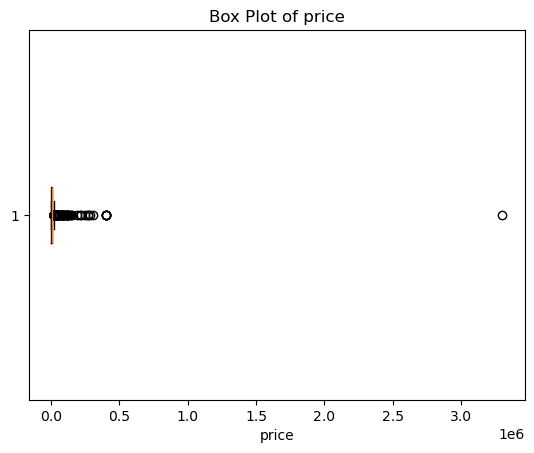

In [2]:
import matplotlib.pyplot as plt

column_name = 'price'
plt.boxplot(data[column_name], vert=False)  # vert=False表示水平方向绘制箱线图
plt.xlabel(column_name)  # 设置x轴标签
plt.title(f'Box Plot of {column_name}')  # 设置标题
plt.show()  # 显示

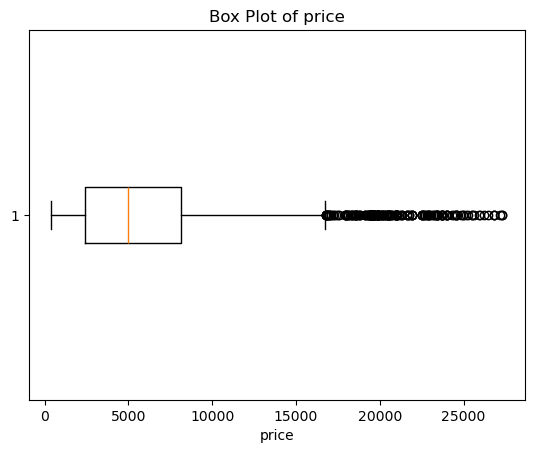

In [3]:
Q1 = data[column_name].quantile(0.25)
Q3 = data[column_name].quantile(0.75)

# 计算IQR（四分位数间距）
IQR = Q3 - Q1

# 定义上界，超出这个范围的数据点被认为是离群值
upper_bound = Q3 + 3.0 * IQR

# 剔除单个离群值，保留非离群值的数据
outliers_index = data[data[column_name] > upper_bound].index
filtered_data = data[data[column_name] <= upper_bound]
data_cleaned = data.drop(outliers_index)
data_cleaned = data_cleaned.reset_index(drop=True)

plt.boxplot(filtered_data[column_name], vert=False)  # vert=False表示水平方向绘制箱线图
plt.xlabel(column_name)  # 设置x轴标签
plt.title(f'Box Plot of {column_name}')  # 设置标题
plt.show()  # 显示

In [4]:
print("Number of rows:", data_cleaned.shape[0])  
print("Number of columns:", data_cleaned.shape[1])

Number of rows: 3333
Number of columns: 33


In [10]:
desired_price = 1400
desired_roomtype = "Private room"
desired_month = 12
desired_latitude = 1.36288
desired_longitude = 103.86575
user_amenities_input = [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

# 设定的权重
weights = {
    'price': 0.5,
    'room_type': 0.1,
    'distance': 0.2,
    'amenities': 0.2  
}

# 计算距离
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # 地球半径，单位为公里
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

# source = filtered_data.copy()
data_cleaned['distance'] = data_cleaned.apply(lambda row: haversine_distance(desired_latitude, desired_longitude, row['latitude'], row['longitude']), axis=1)

# 数据集中的amenities列
amenities_columns = ['conditioning', 'BBQ', 'gym', 'pool', 'dryer', 'Wifi', 'kitchen', 'Backyard', 'TV', 'refrigerator', 'Microwave', 'Oven', 'Pets', 'stove', 'fan']

# 选择对应的roomtype列
roomtype_col = "room_type_" + desired_roomtype

# 选择对应的amenities列
selected_amenities = [amenities_columns[i] for i, val in enumerate(user_amenities_input) if val == 1]
room_types=["room_type_Entire home/apt","room_type_Hotel room","room_type_Private room","room_type_Shared room"]
price=data_cleaned['price'].values
price_loss=price-desired_price


scaler = StandardScaler()
# price_loss_scaled=scaler.fit_transform()

# scaler=MinMaxScaler(feature_range=(-1,1))
#scaler=MinMaxScaler()
price_loss_scaled=scaler.fit_transform(price_loss.reshape(-1,1)).flatten()
# def custom_scaling(X):
#     min_val = X.min()
#     max_val = X.max()

#     scaled_X = -1 + 2 * (X - min_val) / (max_val - min_val)
#     return scaled_X
# price_loss_scaled=custom_scaling(price_loss)
price_loss_scaled_df=pd.DataFrame(price_loss_scaled,columns=['price_loss_scaled'])

vector_cols = selected_amenities + ['distance']+room_types
user_room_type = [1 if roomtype == roomtype_col else 0 for roomtype in room_types]

# 创建user_vector
user_vector = np.array([1] * len(selected_amenities) + [0]+user_room_type+[0])

data_vector = pd.concat([data_cleaned[vector_cols],price_loss_scaled_df],axis=1).values

user_vector=user_vector.reshape(1, -1)
# 计算余弦相似度
similarities = cosine_similarity(user_vector, data_vector)



user_vector_amenities = np.array([1] * len(selected_amenities))
data_vector_amenities = data_cleaned[selected_amenities].values

data_room_type=data_cleaned[room_types].values
user_room_type=np.array(user_room_type).reshape(1, -1)
room_type_loss=1-cosine_similarity(user_room_type, data_room_type)
room_type_loss_df=pd.DataFrame(room_type_loss.T, columns=['room_type_loss'])

amenities_loss=1-cosine_similarity(user_vector_amenities.reshape(1, -1), data_vector_amenities)
amenities_loss_df=pd.DataFrame(amenities_loss.T, columns=['amenities_loss'])
scaler=MinMaxScaler()
distance_scaled=scaler.fit_transform(data_cleaned['distance'].values.reshape(-1, 1))
distance_scaled_df=pd.DataFrame(distance_scaled,columns=['distance'])
loss=pd.concat([amenities_loss_df,distance_scaled_df],axis=1)

# loss_scaled = scaler.fit_transform(loss)

loss_scaled=pd.concat([loss,price_loss_scaled_df],axis=1)
loss_scaled=pd.concat([loss_scaled,room_type_loss_df],axis=1)
# cost=(1-similarities[0])
cost=(1-similarities[0])+ weights['amenities']*loss_scaled['amenities_loss'].values+weights['distance']*loss_scaled['distance'].values+weights['price']*loss_scaled['price_loss_scaled'].values+weights['room_type']*loss_scaled['room_type_loss'].values
data_cleaned['cost'] = cost

# 获取得分最高的Top 10房源
data_cleaned['similarity_score'] = similarities[0]
top_10 = data_cleaned.nsmallest(10, 'cost')
top_10.to_csv('content_based_result.csv')
top_10

,id,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,minimum_months,maximum_months,distance_to_mrt,closest_mrt_name,...,Pets,stove,fan,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,distance,cost,similarity_score
1717,42910492,Serangoon,North-East Region,1.355820,103.864050,1800,3,37,0.468027,LORONG CHUAN MRT STATION,...,1,1,0,0,0,1,0,0.807462,-0.176914,0.779390
1710,42829911,Serangoon,North-East Region,1.355600,103.863760,1800,3,37,0.445562,LORONG CHUAN MRT STATION,...,1,1,0,0,0,1,0,0.839181,-0.173935,0.776657
1275,35744548,Serangoon,North-East Region,1.357310,103.863810,1800,3,37,0.634710,LORONG CHUAN MRT STATION,...,1,1,0,0,0,1,0,0.655827,-0.091600,0.710747
592,19490734,Ang Mo Kio,North-East Region,1.368000,103.856880,1470,6,37,0.786649,ANG MO KIO MRT STATION,...,1,0,0,0,0,1,0,1.138576,-0.069396,0.660288
3256,899732642408799379,Serangoon,North-East Region,1.383397,103.861367,2250,3,5,1.834320,YIO CHU KANG MRT STATION,...,0,1,1,0,0,1,0,2.332882,-0.043184,0.684979
18,733863,Serangoon,North-East Region,1.369260,103.873120,780,6,12,1.668153,KOVAN MRT STATION,...,0,0,0,0,0,1,0,1.083739,-0.019008,0.562829
93,4712676,Ang Mo Kio,North-East Region,1.367470,103.838650,1650,3,37,1.271509,ANG MO KIO MRT STATION,...,0,1,1,0,0,1,0,3.055456,-0.008511,0.597732
373,14131949,Serangoon,North-East Region,1.364640,103.863520,4440,3,37,1.450333,LORONG CHUAN MRT STATION,...,0,1,0,0,0,1,0,0.315834,0.004583,0.850053
1086,32205289,Hougang,North-East Region,1.367200,103.897480,1200,3,37,0.726921,HOUGANG MRT STATION,...,0,1,0,0,0,1,0,3.559773,0.004797,0.544700
2192,53280269,Serangoon,North-East Region,1.356000,103.864370,3000,3,12,0.488507,LORONG CHUAN MRT STATION,...,1,1,1,0,0,1,0,0.780250,0.015631,0.720829
